# Lecture 6 - Sentiment Analysis

In this notebook we will learn how to measure sentiment in text.

Below is the overview of this notebook.
<ol type = 1>
  <li> Measure tweet sentiment</li>
  <ol type = a>
  <li> Load tweets from database</li>
  <li> Load sentiment classifier from huggingface, which in this case is a BERT transformer</li>
  <li>  Measure tweet sentiment with transformer</li>
  </ol>

  <li> Analyze sentiment of tweets </li>
  <ol type = a>
  <li> Plot sentiment versus screen name</li>
  <li> Plot sentiment versus retweet counts</li>
  </ol>

  <li> Visualize tweet embeddings and sentiment </li>
  <li> Measure tweet sentiment using ChatGPT </li>

  <li> Plot transformer word embeddings </li>
  
  </ol>
</ol>

This notebook can be opened in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture06_SentimentAnalysis.ipynb)

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab.  This will save the notebook in your Google Drive.

# Clones, imports, and GPU

## Using a GPU

If we switch the run-time to a GPU (graphical processing unit), the neural network computations will run faster.  To do this, go to the top left menu and select **Runtime-> Change runtime type -> Harware accelerator -> GPU**.  

The code below will tell you if your Colab runtime is using a GPU.

In [38]:
# Check if GPU is available and set PyTorch to use the GPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


## Clone GitHub Repository
This will clone the repository to your machine.  This includes the code and data files.  Then change into the directory of the repository.

In [2]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 668 (delta 119), reused 195 (delta 82), pack-reused 435
Receiving objects: 100% (668/668), 75.25 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (351/351), done.
Updating files: 100% (67/67), done.


## Import Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from transformers import pipeline

import codecs  #this let's us display tweets properly (emojis, etc.)

pd.set_option("display.max_colwidth", None)
#this code makes the default font sizes big in plots
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})


# Download Transformer

We can download different transformer models from the Hugging Face website https://huggingface.co/models.  All we need to do is fine the page of a model, and copy its `model_path`.  Then we can load the model using the `pipeline` function.

We will download the model from https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment.  This is a pre-trained model in the huggingface library that was trained on product reviews in multiple languages.  The output sentiment is between 1 and 5.
The `model_path` is `"nlptown/bert-base-multilingual-uncased-sentiment"`.

The model `output` is a list of dictionaries which contain the probability distribution of the sentiment, which is not what we want. Later on we will write a function that returns just the sentiment mean value.

In [39]:
#This is the model we will use on the homework
model_path = "nlptown/bert-base-multilingual-uncased-sentiment"
model = pipeline(
    model=model_path,
    return_all_scores=True
)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



In [40]:
text = "j'adore mon travaille"
output  = model(text)
output


[[{'label': '1 star', 'score': 0.004472776781767607},
  {'label': '2 stars', 'score': 0.005466333590447903},
  {'label': '3 stars', 'score': 0.06525950133800507},
  {'label': '4 stars', 'score': 0.31684887409210205},
  {'label': '5 stars', 'score': 0.6079525351524353}]]

In [41]:
#You can try another model if you like for fun
model_path="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
model_1 = pipeline(
    model=model_path,
    return_all_scores=True
)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



In [42]:
text = "j'adore mon travaille"
output  = model_1(text)
output

[[{'label': 'positive', 'score': 0.7334911227226257},
  {'label': 'neutral', 'score': 0.15143738687038422},
  {'label': 'negative', 'score': 0.11507153511047363}]]

# Measuring Sentiment with a Transformer

We will pass the tweets through a pre-trained transformer sentiment classifier.

### Define Sentiment Classifier Function

We will create a function called `sentiment_classifier` which takes as input a string `text`, a transformer model called `model`, and a tokenizer called `tokenizer`, and returns the `sentiment` of the text.  The raw sentiment output of the model is a probability for each sentiment value.  The function will return the average sentiment based on these probabilities.  


In [6]:
def sentiment_classifier(text, model):
  output  = model(text)
  p = np.array([x['score']  for x in output[0]])  #probability of each sentiment value
  score = np.arange(1,6)  #value of the sentiments for the probabilities
  sentiment = np.dot(p,score)  #mean sentiment
  sentiment = sentiment/5  #normalize sentiment so it is in [0,1]
  return sentiment



### Sentiment Classification Example
Now we can test the model on some text.  Feel free to try any text you want here.  Just put your text in the list `texts`.

In [10]:
texts = ["This class is kinda boring, but informative",
        "This class is awesome",
        "this class is stupid",
        "this class is dope",
       "this class slaps",
       "this class is fun",
       "this class is fun!",
       "this class is :(",
       "this class is :)"]

In [11]:
for text in texts:
  sentiment = sentiment_classifier(text,model)
  print(f"Sentiment:{sentiment:.2f}\nText: {text}\n")

Sentiment:0.62
Text: This class is kinda boring, but informative

Sentiment:0.97
Text: This class is awesome

Sentiment:0.25
Text: this class is stupid

Sentiment:0.55
Text: this class is dope

Sentiment:0.31
Text: this class slaps

Sentiment:0.85
Text: this class is fun

Sentiment:0.89
Text: this class is fun!

Sentiment:0.71
Text: this class is :(

Sentiment:0.86
Text: this class is :)



# Measuring Tweet Sentiment

### Load Tweets

Load the tweets from the file `"data/lec_06_tweets_sentiment_embedding.csv"` into a dataframe `df`.  You can use the `pd.read_csv` function to do this.

In [12]:
df = pd.read_csv("data/lec_06_tweets_sentiment_embedding.csv")
ntweets = len(df)
print(f"dataframe has {ntweets} tweets")
df.sample(n=5)

dataframe has 18533 tweets


,screen_name,text,retweet_count,sentiment,star,umap_transformer_x,umap_transformer_y
7481,BarackObama,"When 97 percent of climate scientists agree, it^s time for the deniers to put politics aside and #ActOnClimate. http://t.co/mbHMhbVJK9",2802,0.442352,5,10.185527,0.817941
11029,JBALVIN,Mi cama REMIX hoy a la medianoche @KarolGmusic @nickyjampr pronto el video !! #micamaremix https://t.co/fWbPMmoINs,166,0.758218,8,5.214698,4.007551
2572,elonmusk,"@DavidMainayar Napoleon was incredible. \u201cIt is my wish that my ashes may repose on the banks of the Seine, in the m\u2026 https://t.co/4DRSn59M7d",204,0.758285,8,9.610974,5.859311
15240,AOC,"RT @RashidaTlaib: A young Marine taught me that saying ""thank you for your service"" is simply not enough &amp; can be seen as offensive when so\u2026",3392,0.480701,5,10.793123,1.033086
15059,AOC,RT @nowthisnews: \u2018The market has decided that women and people who give birth deserve less time with their children than a dog.\u2019 \u2014\xa0@AOC exp\u2026,3807,0.477146,5,10.358191,1.506905


### Calculate Sentiment and Transformer Embedding of Tweets
**Don't need to run this in class because it takes an hour**.

We use a for loop iterating over the rows in `df` to calculate the sentiment of each tweet.  We store the sentiment in the list `Sentiment`.  We then add the sentiment to a column in `df`.   The speed of this code depends on if you use a CPU or GPU:

CPU = 9000 tweets/hour

GPU = 23000 tweets/hour






In [ ]:
%%time
c = 0
Sentiment = []
for index,row in df.iterrows():  #iterate over rows of dataframe
  c+=1
  if c%1000==0:print(f"Tweet {c}/{len(df)}")  #print progres every 1000 rows

  sentiment = sentiment_classifier(row.text,model)  #calculate sentiment and embedding of tweet
  Sentiment.append(sentiment)  #append sentiment of tweet to Sentiment list


In [ ]:
df['sentiment'] = Sentiment  #add sentiment column to dataframe of tweets
df.head()

#### Save sentiments


You can save the resulting dataframe to a file with the `pd.to_csv` function.  We will set `fname_sentiment` equal to the path and filename where you want to save the data.  Once the file is save, download it using the file menu on the left.  Later on if you want to analyze this file, you can upload it to the `"social_media_analytics/data"` folder.

In [39]:
#uncomment the lines below to save tweets, sentiment, and embedding to a csv file
#fname_sentiment = "/content/social_media_analytics/data/lec_06_tweets_sentiment_v1.csv"
#df.to_csv(fname_sentiment)


# Analyze Tweet Sentiment

### Load Tweets and Sentiment

Once we save the tweet sentiments, the next time we run the notebook we can just load this data instead of recalculating the sentiment.  The sentiment is in the file `"data/lec_06_tweets_sentiment_embedding.csv"`.

In [44]:
# prompt: load "data/lec_06_tweets_sentiment_embedding.csv" into df

df = pd.read_csv("data/lec_06_tweets_sentiment_embedding.csv")
df.head(2)

,screen_name,text,retweet_count,sentiment,star,umap_transformer_x,umap_transformer_y
0,elonmusk,@Teslarati SpaceX in south Texas &amp; Tesla in central have been providing direct assistance where feasible (eg save c\u2026 https://t.co/IHZY4O61U3,1404,0.707079,8,11.595250,4.034751
1,elonmusk,@someone3201 @ERCOT_ISO Yes,208,0.568256,6,6.550869,5.978009


### Average User Sentiment

We make a bar plot of the average sentiment of each user.  We do this using the `barplot` function.

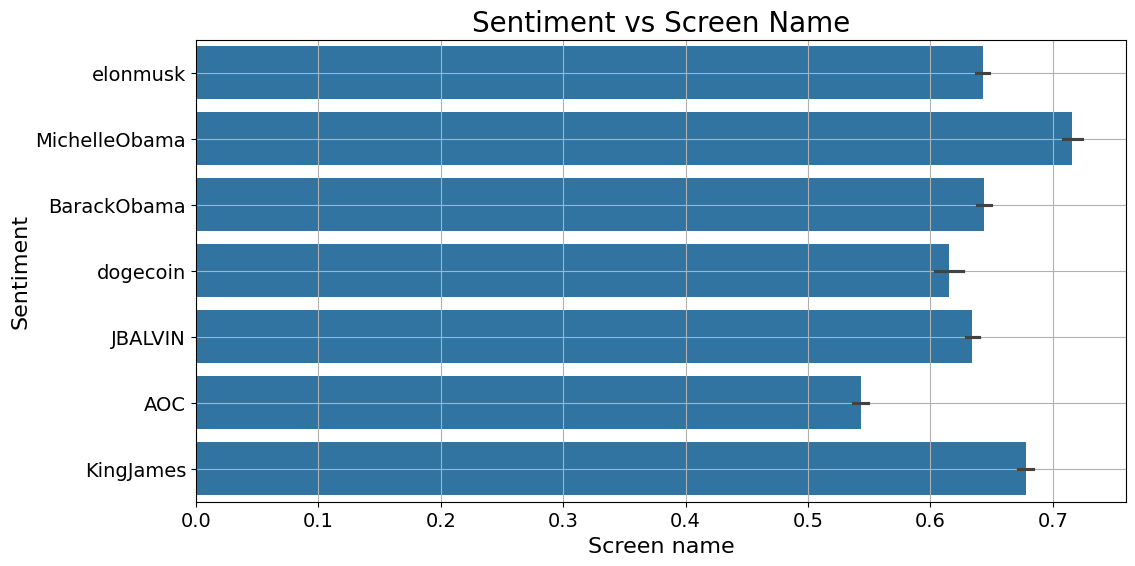

In [14]:
# prompt: make a horizonatl barplot of sentiment vs screen_name in df.  make the bars bright orange and title the plot and add a grid

fig = plt.figure(figsize = (12,6))
sns.barplot(data = df, x= 'sentiment', y = 'screen_name')
plt.xlabel("Screen name",fontsize = 16)
plt.ylabel("Sentiment",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Sentiment vs Screen Name",fontsize = 20)
plt.grid()

### Sentiment Distribution per User

We can make histograms of the tweet sentiment for each user.  We use a `for` loop to iterate through each screen name.
We use the `histplot` function to make a histogram of the tweets of each user.  We also add a title to each plot so we know whose tweets they are.

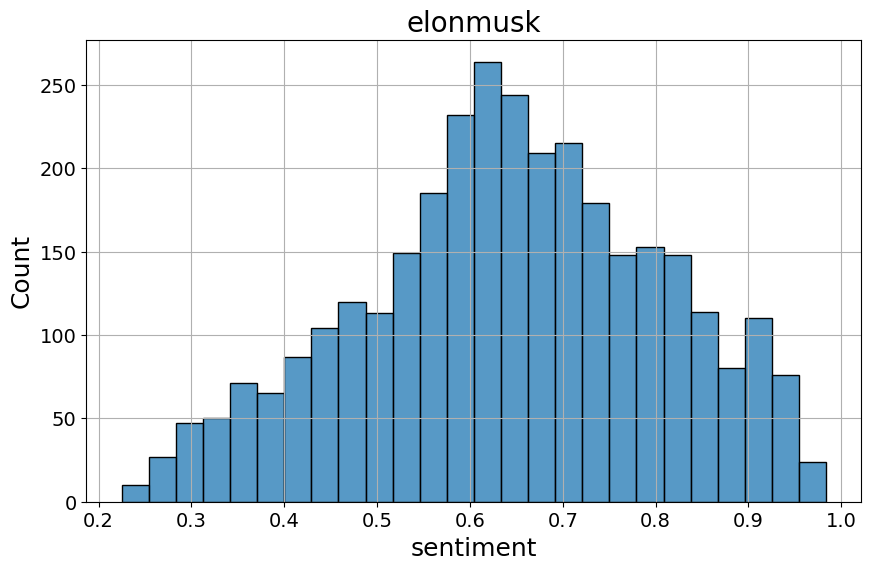

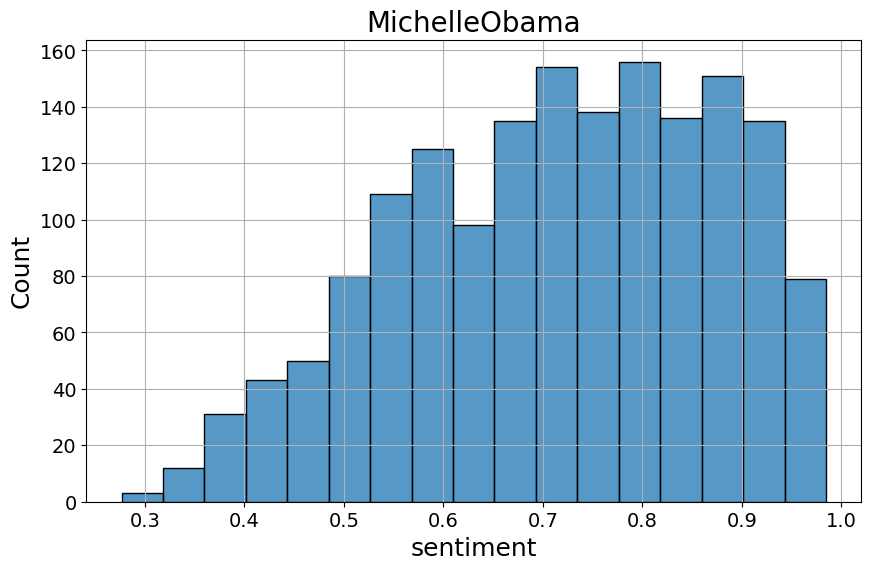

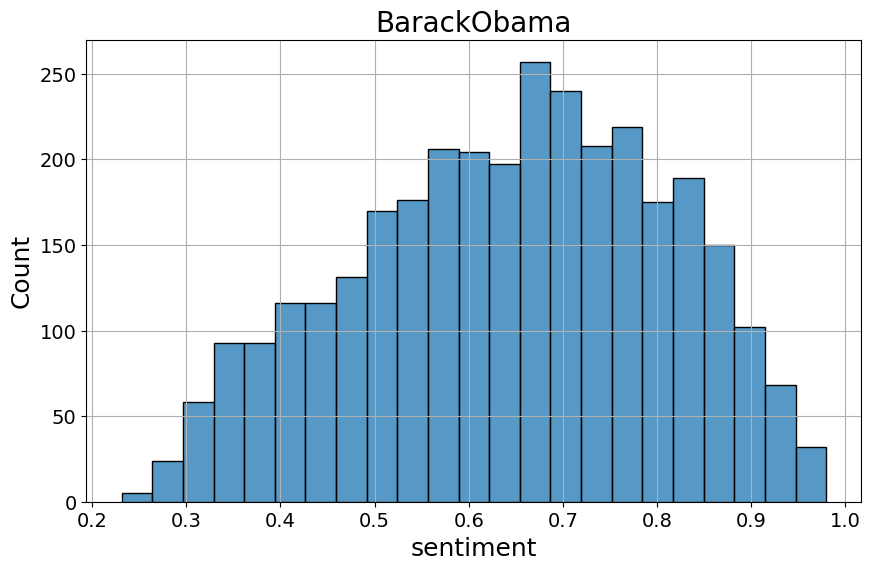

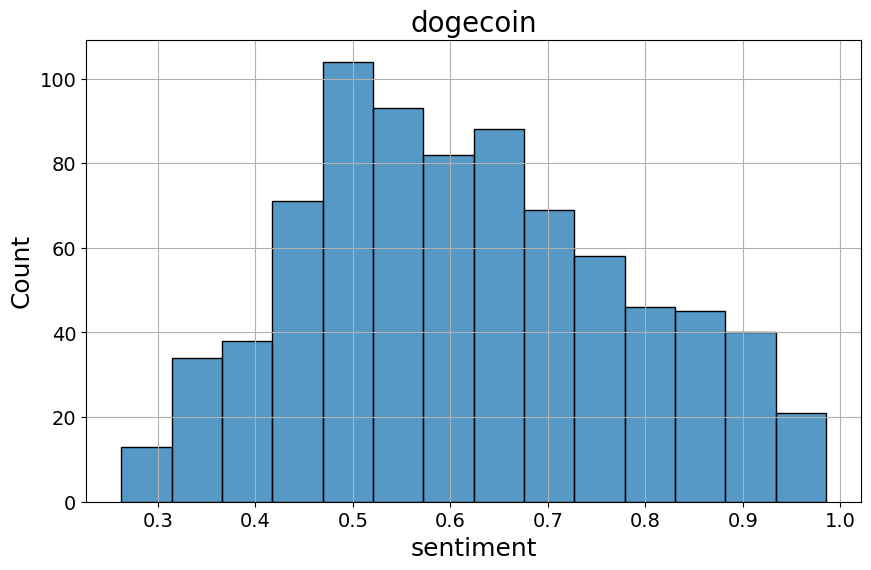

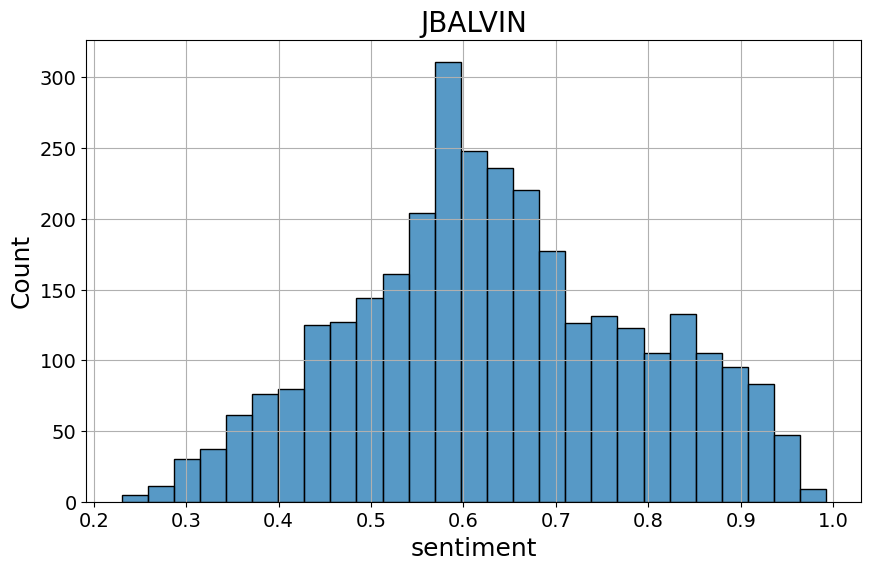

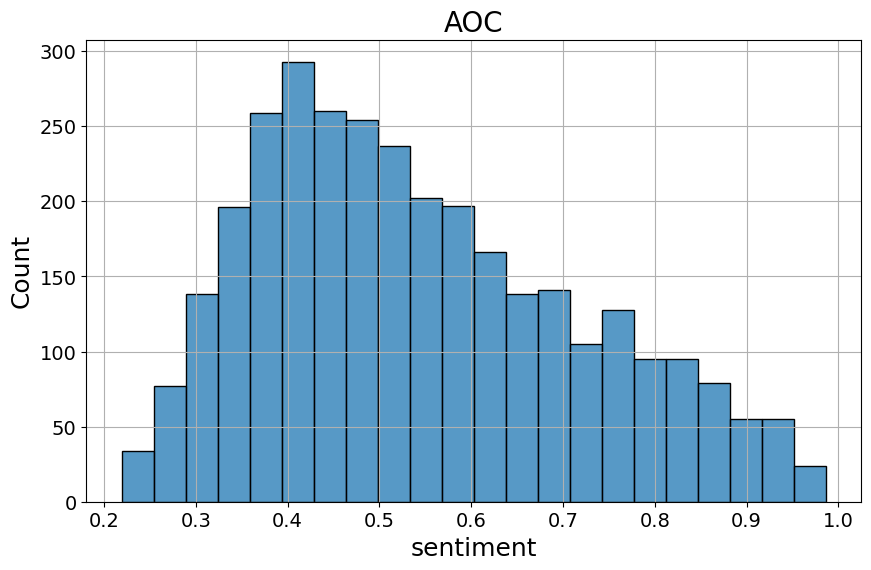

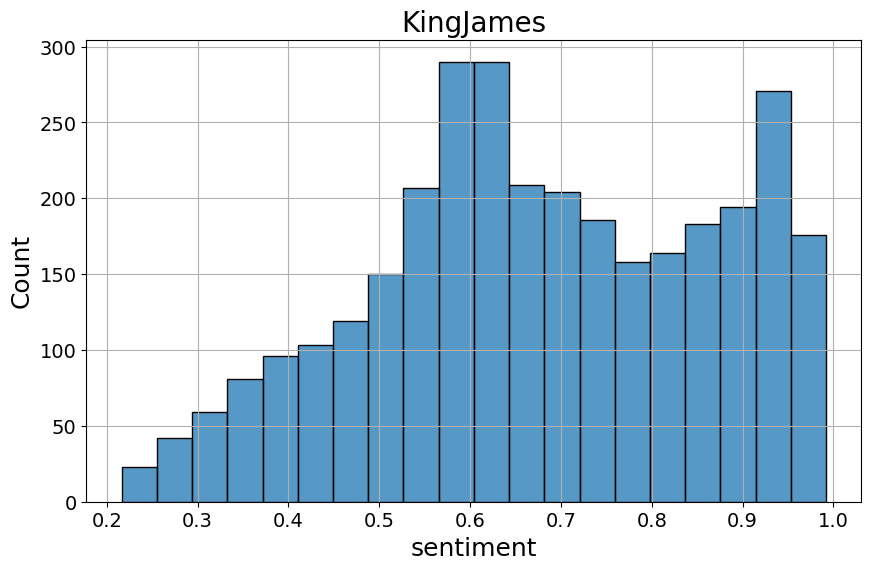

In [15]:
# prompt: Plot a histogram of sentiment for each screen_name in df.  add a title of hte screen_name to each plot

for screen_name in df.screen_name.unique():
    df_screen_name = df[df.screen_name == screen_name]
    plt.figure(figsize = (10,6))
    sns.histplot(data = df_screen_name, x = 'sentiment')
    plt.title(screen_name,fontsize = 20)
    plt.grid()
    plt.show()


### Look at Tweets with Extreme Sentiment

We can select tweets of each user with very high or very low sentiment and print them out.  We do this by keeping the rows of `df` with the corresponding screen name, and then using `sort_values` to sort the user's tweets by sentiment.  We set `ascending = True` inside the `for` loop to get the most postive tweets, and set `ascending = False` to get the most negative tweets.  We set `ndisplay` equal to the number of tweets we want to print per user.

To show all the funny Twitter characters, we need to use the `decode` function in the `codecs` module.



In [16]:
# prompt: display the top 3 text and sentiment for each screen_name in df with the highest value for sentiment

for screen_name in df.screen_name.unique():
    df_plot = df[df.screen_name == screen_name]
    df_plot = df_plot.sort_values(by='sentiment', ascending=False)
    print(f"Most positive tweets of {screen_name}")
    for i in range(3):
        text = codecs.decode(df_plot.iloc[i]['text'], 'unicode_escape')
        print(f"\tSentiment: {df_plot.iloc[i]['sentiment']:.2f}")
        print(f"\tText: {text}\n")

    df_plot = df_plot.sort_values(by='sentiment', ascending=True)
    print(f"Most negative tweets of {screen_name}")
    for i in range(3):
        text = codecs.decode(df_plot.iloc[i]['text'], 'unicode_escape')
        print(f"\tSentiment: {df_plot.iloc[i]['sentiment']:.2f}")
        print(f"\tText: {text}\n")


Most positive tweets of elonmusk
	Sentiment: 0.98
	Text: Such a privilege to work with people I like &amp; respect so much. I feel blessed. 

	Sentiment: 0.98
	Text: One of the all-time best songs https://t.co/IvI7IOgMAa 

	Sentiment: 0.98
	Text: @lrocket Thanks for everything you did to help build SpaceX! Some of the best memories ever. 

Most negative tweets of elonmusk
	Sentiment: 0.22
	Text: @Amro_Alzeiq @CNN @GavinNewsom I literally have the receipts!! This is so dumb. 🤣🤣 

	Sentiment: 0.23
	Text: @flcnhvy @RationalEtienne @chrish7985 @rlyrlysryDave Klippenstein has gone full twitter troll. Big mistake. Never go full troll! 

	Sentiment: 0.23
	Text: @pesachlattin This is false. I have never introduced either of them to anyone. 

Most positive tweets of MichelleObama
	Sentiment: 0.98
	Text: Happy 20th anniversary, Barack. Thank you for being an incredible partner, friend, and father every day. I love you! –mo 

	Sentiment: 0.98
	Text: One of my greatest joys as First Lady was getti

### Plot of Retweet Count vs Sentiment

To see this correlation of extreme sentiment and engagement, we can use a `barplot`.

 We first create a column called `star` that converts the sentiment to an integer between 1 and 10.  Then we can make a barplot of the `like_count` versus the `star`.  

In [17]:
# prompt: create df['star'] which is df['sentiment'] times 100, then given a value 1,2,3,..,10 if it is in [0,10], [11,20], etc

df['star'] = df['sentiment']*100
df['star'] = (df['star']//10).astype(int)+1


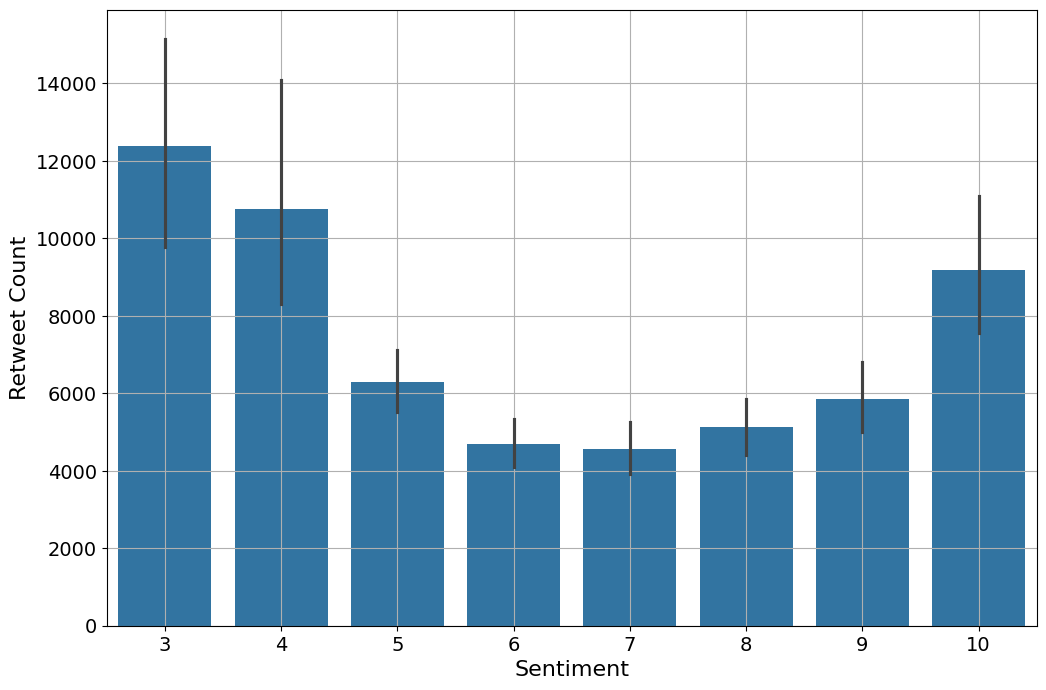

In [18]:
fig = plt.figure(figsize = (12,8))
ax = sns.barplot(data=df, x="star", y="retweet_count")
plt.xlabel("Sentiment", fontsize = 16)
plt.ylabel("Retweet Count", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.grid()
plt.show()

### Plot Retweet Count vs Sentiment per User

We can also look at a plot for each individual user.  

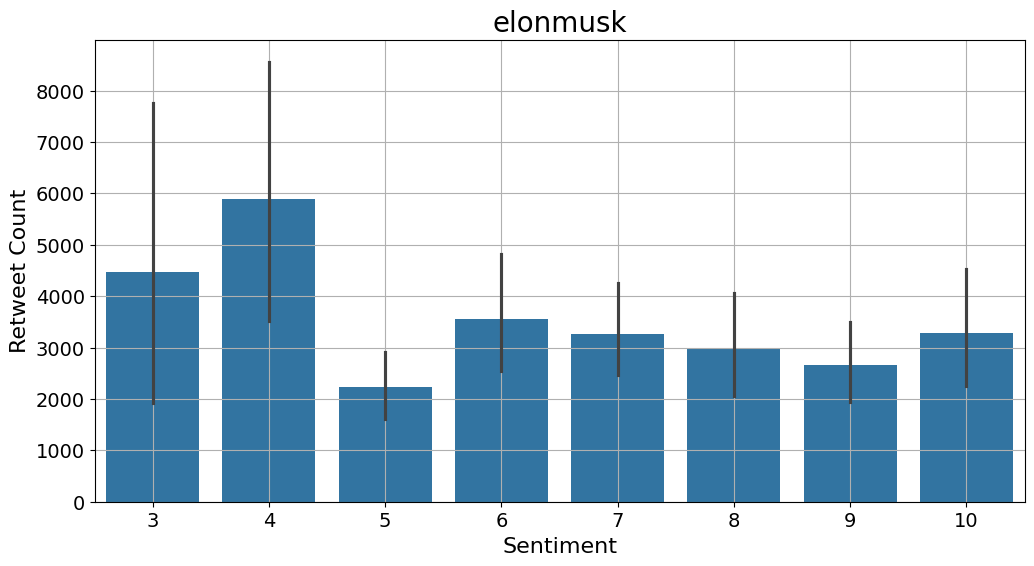

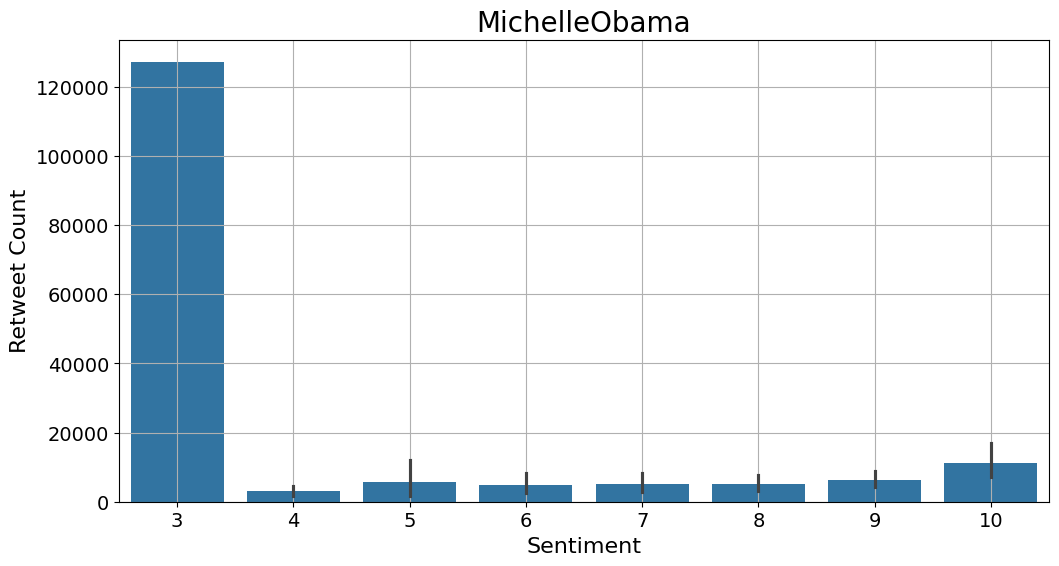

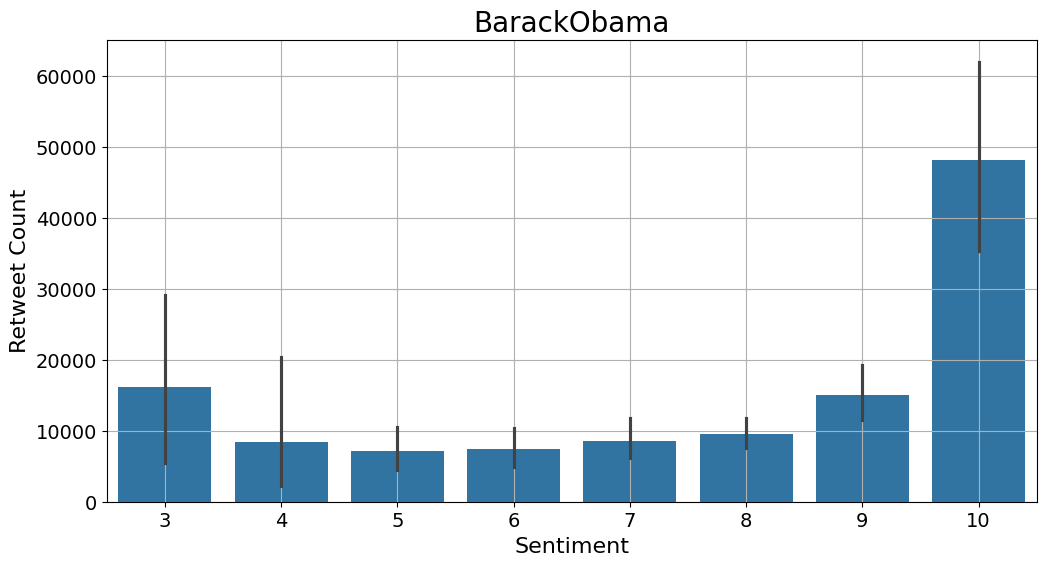

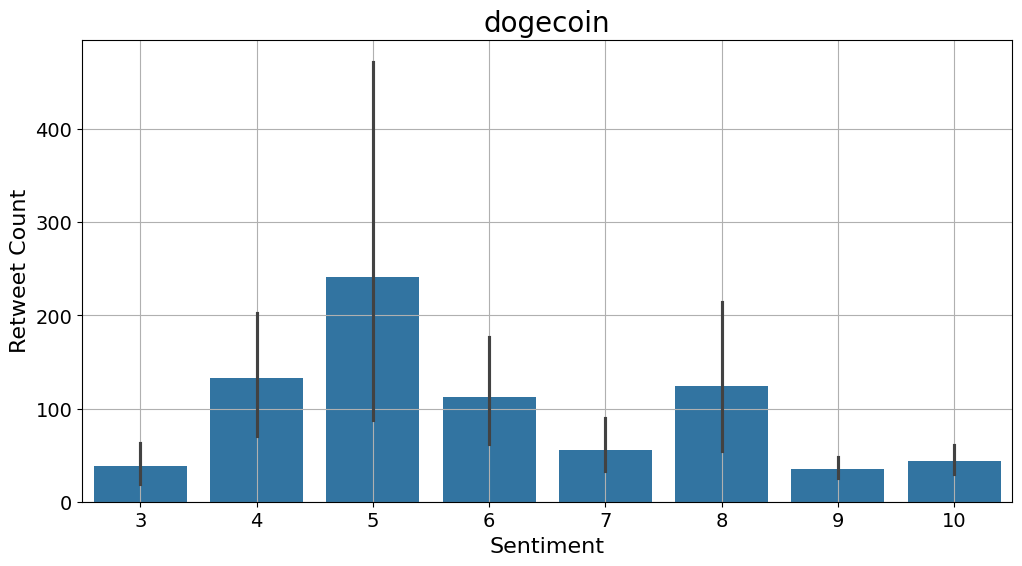

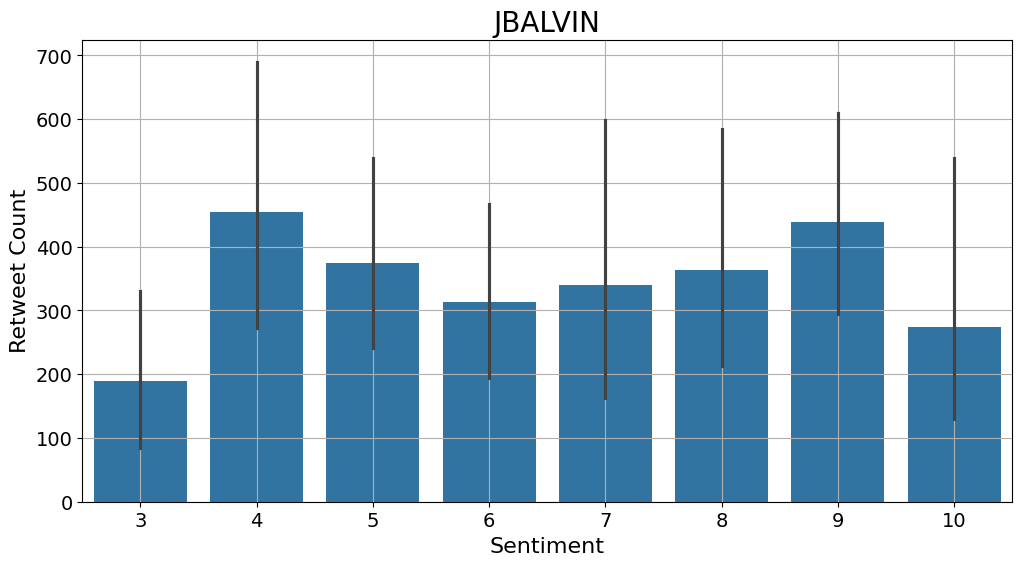

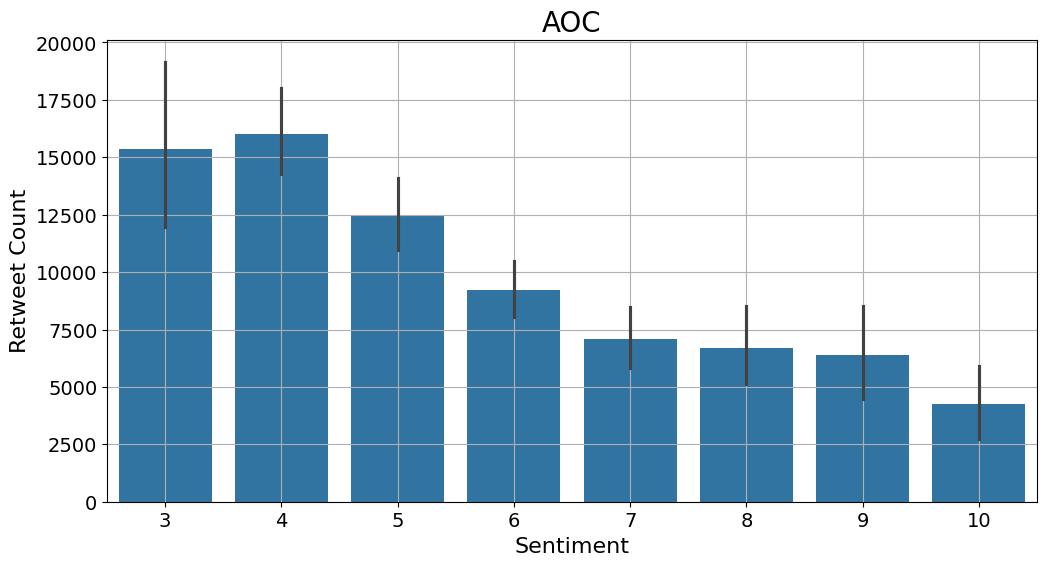

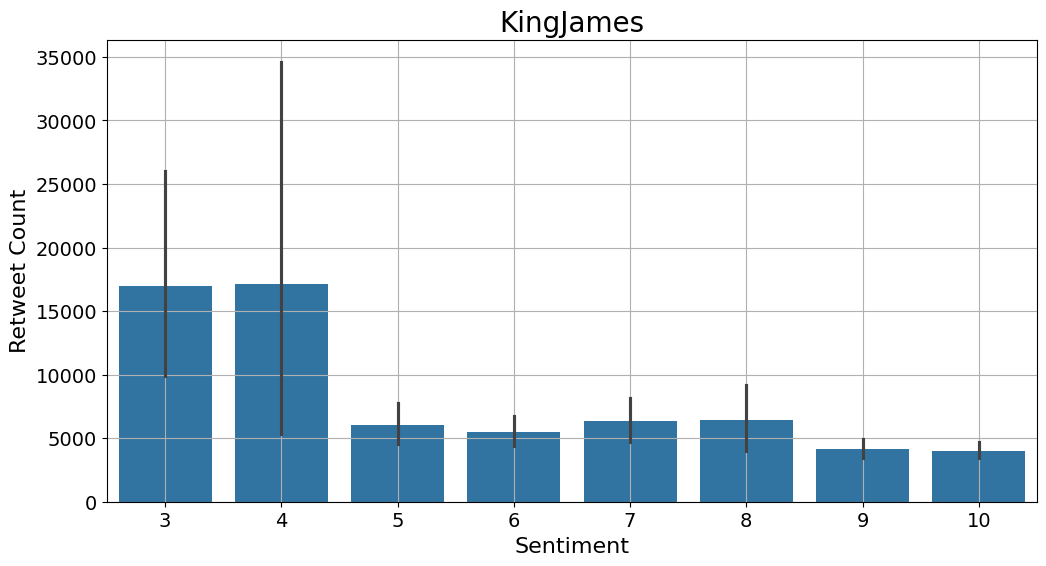

In [19]:
for screen_name in df.screen_name.unique():
  df_plot = df[df.screen_name==screen_name]
  fig = plt.figure(figsize=(12,6))
  sns.barplot(data = df_plot, x = 'star', y = 'retweet_count')
  plt.xlabel("Sentiment", fontsize = 16)
  plt.ylabel("Retweet Count", fontsize = 16)
  plt.title(f"{screen_name}", fontsize = 20)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.grid()
  plt.show()


# Visualize Transformer Embedding

Now we will visulize the transformer embeddings using the UMAP algorithm to see how the sentiment is distributed.  UMAP is similar to t-SNE.  The embedding has been pre-calculated for you to save time.

### Scatter Plot of Transformer Tweet Embeddings

We can make a scatter plot of the  transformer embeddings of the tweets.  We will color the data points by the user screen name.  We will also make another plot next to this plot where we color the data points by sentiment.  You set the column for the datapoint color with the `hue` parameter.  You can choose a color palette with the `palette` parameter.  There are many palettes you can choose from, but for discrete values like `"screen_name"` use the `"bright"` palette and for continous values like `"sentiment"` use the `"vlag"` palette.  Of course feel free to try other palettes. A complete list can be found here: https://seaborn.pydata.org/tutorial/color_palettes.html


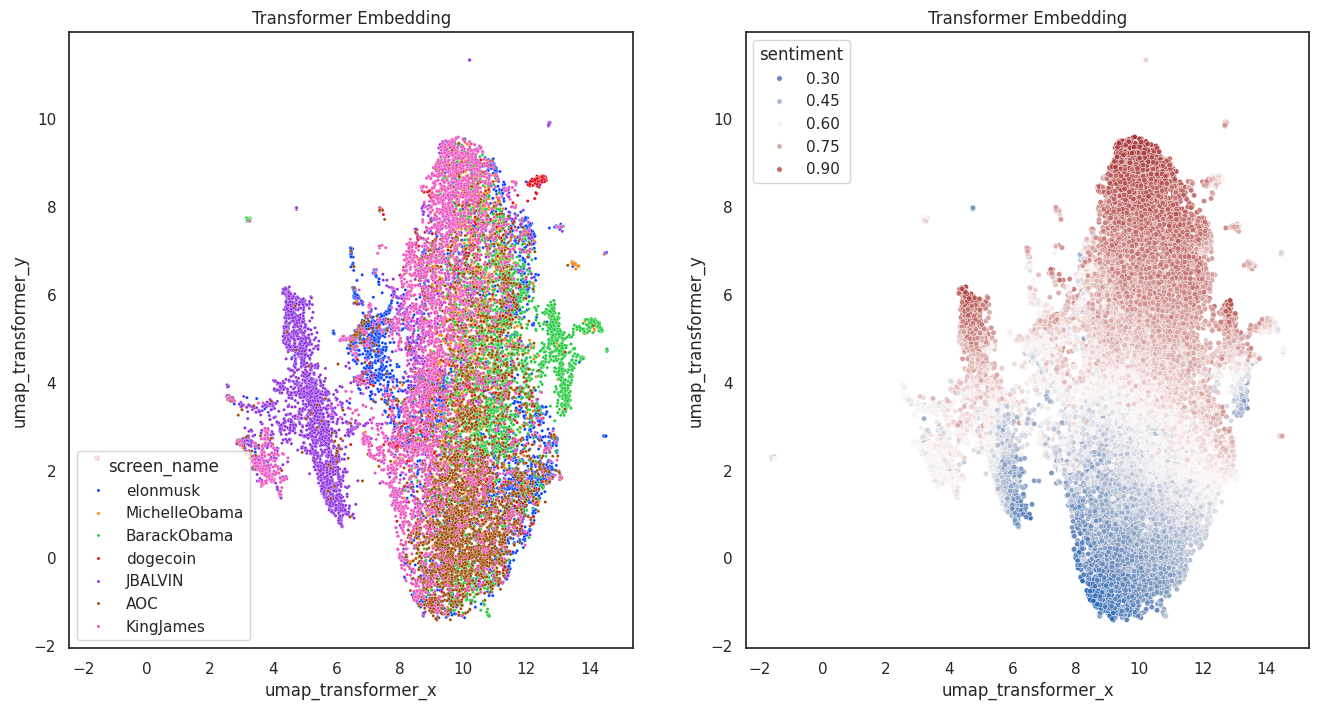

In [99]:
fig = plt.figure(figsize = (16,8))
ax1 = plt.subplot(1,2,1)
sns.scatterplot(data=df, x="umap_transformer_x",
                y="umap_transformer_y",
                hue="screen_name",
                palette="bright", s=5)
plt.title("Transformer Embedding")

ax2 = plt.subplot(1,2,2)
sns.scatterplot(data=df, x="umap_transformer_x",
                y="umap_transformer_y",
                hue="sentiment",
               palette="vlag", s=15)
plt.title(f"Transformer Embedding")
plt.show()

# Measuring Sentiment with ChatGPT (optional)

We can use ChatGPT as a sentiment classifier as well.  This will cost money, so you do not need to run this code if you do not want to.

If you want to use this code, you will need to get your API key from openai.com

To make ChatGPT return the sentiment of text, we need to write a prompt with the instructions, `instructions`.  Then we append to this the

## Install openai

In [20]:
!pip install openai -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [21]:
import openai, os, json, re

## OpenAI API Key

You will need to input your OpenAI API key.  

1.  First you need to create an account with OpenAI here: https://auth0.openai.com/u/signup?state=hKFo2SBWS3JUVEdmQmdzZXo5ckhpY3R5NEFlc2NPWWc3WHhvRqFur3VuaXZlcnNhbC1sb2dpbqN0aWTZIG9kTDB4LV83aEdnN3pRU3VUYnVZemlnZkFURFo2RDhno2NpZNkgRFJpdnNubTJNdTQyVDNLT3BxZHR3QjNOWXZpSFl6d0Q

2. Once you have an account, copy your API key from here: https://beta.openai.com/account/api-keys

3. Finally, paste your key below:  `OPENAI_API_KEY = "your OpenAI API key"`




In [22]:
os.environ['OPENAI_API_KEY'] = 'your key here'
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

client = openai.Client(api_key=OPENAI_API_KEY)

## Measure Sentiment

The function `get_score` will return the sentiment of the text in `user_input`.  You will also need to give ChatGPT instructions in a string `instructions` and select which GPT `model` you want to use (you can find the models here https://platform.openai.com/docs/guides/text-generation).

In [24]:
def chatgpt_sentiment(user_input, instructions, model = "gpt-4-turbo-preview"):
    completion = client.chat.completions.create(
        model = model,
        messages=[
        {"role": "system", "content": instructions},
        {"role": "user", "content": user_input}
        ]
    )
    response =completion.choices[0].message.content
    pattern = r'\{([^}]*)\}'
    match = re.findall(pattern, response.strip('\n'))[0]
    data = json.loads('{' + match + '}')
    score = data['sentiment']

    return score

In [31]:
instructions = '''You will be given text from Twitter.
Your task will be to measure the sentiment of the text
on a scale from 0 to 100 where 0 means very negative about Taylor Swift
and 100 means very positive about her.  Return only a JSON formatted
text with key "sentiment" (the sentiment score from 0 to 100).'''




In [32]:
user_input = '''Taylor Swift has 4 album of the year grammys, why does Beyonce
 have none?  Beyonce is a way better singer and dancer.
'''

In [26]:
#calculate sentiment
sentiment  = chatgpt_sentiment(user_input, instructions)

#print sentiment and text
print(f"Sentiment: {sentiment}/100\nText: {user_input}")


Sentiment: 30/100
Text: Taylor Swift has 4 album of the year grammys, why does Beyonce
 have none?  Beyonce is a way better singer and dancer.  



# Embedding Words (optional)

The code below allows you to create an embedding plot of words in sentences using a transformer embedding.

In [27]:
from transformers import BertTokenizer, BertModel

import torch
from sklearn.decomposition import PCA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px


In [28]:
# Load the pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [34]:
texts = []
texts.append('A bat flew out of the cave')
texts.append('A bat flew out of the baseball players hand')
texts.append("The bat pooped on the ground")
texts.append("A bat bit me in the neck")
texts.append("I hit a home run with the metal bat")
texts.append("Im afraid of a bat because it is like a rat with wings")
texts.append("No one swung a bat harder than Babe Ruth")

keyword = 'bat'  #the keyword will be plotted in red


In [36]:
dict_list = []
for text in texts:
  inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)
  input_ids = inputs['input_ids']
  output = model(input_ids, return_dict=True,output_hidden_states=True)

  Y = output['last_hidden_state'].squeeze().detach().numpy()
  print(text)
  ids = inputs['input_ids'].detach().numpy()[0]
  for cnt,id in enumerate(ids):
    w = tokenizer.decode(id).replace(" ","")
    if (w=='[CLS]') | (w=='[SEP]'):
      pass
    else:
      dict_list.append({'word':w,
                        'text':text,
                        'embedding':Y[cnt,:]})
df_embed = pd.DataFrame(dict_list)
embeddings_matrix = np.stack(df_embed['embedding'].values)

pca = PCA(n_components=2)
pca.fit(embeddings_matrix)
pca_result = pca.fit_transform(embeddings_matrix)

df_embed['x'] = pca_result[:, 0]
df_embed['y'] = pca_result[:, 1]


A bat flew out of the cave
A bat flew out of the baseball players hand
The bat pooped on the ground
A bat bit me in the neck
I hit a home run with the metal bat
Im afraid of a bat because it is like a rat with wings
No one swung a bat harder than Babe Ruth


In [37]:
# prompt: make an interactive scatterplot of df_embed['x'] vs df_embed['y'] with hover text 'word' and 'text'.  make the dot red if word==keyword

import plotly.express as px

fig = px.scatter(df_embed, x="x", y="y", hover_data=["word", "text"])
fig.update_traces(marker=dict(size=10, color="red", opacity=0.8))

fig.update_traces(
    marker=dict(
        color=np.where(df_embed['word'] == keyword, 'red', 'blue'),
        size=10,
        opacity=0.8
    )
)

fig.show()
